In [11]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

%matplotlib inline

Work to reproduce results as shown in www.alonsomora.com/docs/10-alonsomora.pdf

First let's define some utility functions for calculating equation 13

In [12]:
# Approximation for calculations close to 0
epsilon = 1e-7

def v_star_error_left_hand(T, theta, error):
    return (error / T) * (theta * np.sin(theta)) / (2.0 * (1.0 - np.cos(theta)))

def v_star_error_right_hand(theta):
    twice_one_minus_cos_theta = 2.0 * (1.0 - np.cos(theta))
    value_for_sqrt = twice_one_minus_cos_theta / (twice_one_minus_cos_theta - np.square(np.sin(theta)))
    return np.sqrt(value_for_sqrt)

def v_star_error(T, theta, error):
    return v_star_error_left_hand(T, theta, error) * v_star_error_right_hand(theta)

def beta(T, theta, max_vel_omega):
    numerator = -(2.0 * np.square(T) * np.sin(theta) * max_vel_omega)
    denominator = theta
    return numerator / denominator

def gamma(T, theta, error, max_vel_omega):
    numerator = 2.0 * np.square(T) * (1.0 - np.cos(theta)) * np.square(max_vel_omega)
    denominator = np.square(theta)
    return (numerator / denominator) - np.square(error)

Define equation 13

In [13]:
# Notice v_h_max is not mathematically well defined when theta is 0, in which case
# the solution is to return max_vel
# This function returns the velocity and and int specifying which region it belongs to
def v_h_max(error, T, max_ang_vel, max_vel, max_vel_omega, theta):
    # if angle is close to zero return max_vel
    if abs(theta) <= epsilon:
        return max_vel, 0
    # Can't reach angle in time (desired angle greater than max angular velocity)
    if (abs(theta / T)) > max_ang_vel:
        v_h = np.sign(theta) * error * max_ang_vel / theta
        return min(v_h, max_vel), 2
    if v_star_error(T, theta, error) <= max_vel_omega:
        return min((error / T) * v_star_error_right_hand(theta), max_vel), 0
    a = np.square(T)
    b = beta(T, theta, max_vel_omega)
    g = gamma(T, theta, error, max_vel_omega)
    return min((-b + np.sqrt(np.square(b) - 4 * a * g)) / (2 * a), max_vel), 1

Fix values and plot velocity values for different angles

In [14]:
# Fixed values presented in section 2.1
max_ang_vel = 4.96
max_vel = 0.13
wheel_length = 0.0525

# Fixed values taken from fig 3 left
T = 0.5
error = 0.01

# Function defined in Theorem 2's proof to calculate Vmax,ω (here called max_vel_omega)
max_vel_omega = lambda omega, T, wheel_length, max_vel: max_vel - (abs(omega) * wheel_length / (2 * T))

turning_angle_space = np.linspace(-np.pi, np.pi, 200)

velocities_and_regions = [v_h_max(error, T, max_ang_vel, max_vel, max_vel_omega(theta, T, wheel_length, max_vel), theta) for theta in turning_angle_space]
velocities = np.array([vel for vel, _ in velocities_and_regions])
regions = np.array([region for _, region in velocities_and_regions])

velocity_region0 = velocities[regions == 0]
turning_angle_region0 = turning_angle_space[regions == 0]
velocity_region1 = velocities[regions == 1]
turning_angle_region1 = turning_angle_space[regions == 1]
velocity_region2 = velocities[regions == 2]
turning_angle_region2 = turning_angle_space[regions == 2]

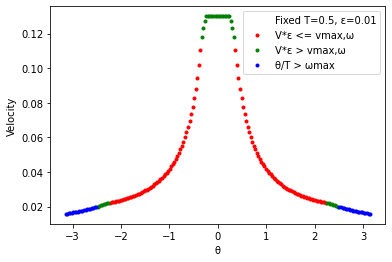

In [15]:
def plot_experiment_values(T, error):
    plt.plot([], [], ' ', label=f"Fixed T={T}, ε={error}")

setup = (
    (turning_angle_region0, velocity_region0, "r.", "V*ε <= vmax,ω"),
    (turning_angle_region1, velocity_region1, "g.", "V*ε > vmax,ω"),
    (turning_angle_region2, velocity_region2, "b.", "θ/T > ωmax")
)
# Plot velocities obtained by applying equation 13
plot_experiment_values(T, error)
plt.xlabel("θ")
plt.ylabel("Velocity")
for turning_angle, velocity, colour, label in setup:
    plt.plot(turning_angle, velocity, colour, label=label)
    
plt.legend()

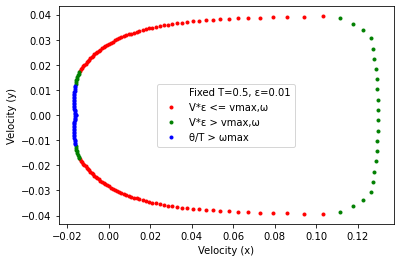

In [16]:
# plot Vx and Vy obtained by applying equation 13, this result should match fig 3
plot_experiment_values(T, error)
plt.xlabel("Velocity (x)")
plt.ylabel("Velocity (y)")
for turning_angle, velocity, colour, label in setup:
    if len(turning_angle) == 0:
        continue
    v_x = np.cos(turning_angle) * velocity
    v_y = np.sin(turning_angle) * velocity
    plt.plot(v_x, v_y, colour, label=label)

plt.legend()

Define functions to reproduce figure 3

In [17]:
def calculate_velocity_components(max_ang_vel, max_vel, T, error, turning_angle_space):
    y = [v_h_max(error, T, max_ang_vel, max_vel, max_vel_omega(theta, T, wheel_length, max_vel), theta)[0] for theta in turning_angle_space]
    v_x = np.cos(turning_angle_space) * y
    v_y = np.sin(turning_angle_space) * y
    return v_x, v_y

def plot_fig3_left(max_ang_vel, max_vel):
    error = 0.01
    turn_values_90_degrees = np.linspace(epsilon, np.pi / 2, 200)
    plt.plot([], [], ' ', label=f"Fixed ε={error}")
    for T, colour, linestyle, label in ((0.2, "b", "--", "T=0.2s"), (0.35, "g", "-", "T=0.35s"), (0.5, "brown", "-.", "T=0.5s")):
        v_x, v_y = calculate_velocity_components(max_ang_vel, max_vel, T, error, turn_values_90_degrees)
        plt.plot(v_x, v_y, color=colour, linestyle=linestyle, label=label)
    plt.xlim(left=0)
    plt.legend()

def plot_fig3_right(max_ang_vel, max_vel):
    T = 0.35
    turn_values_180_degrees = np.linspace(-np.pi / 2, np.pi / 2, 200)
    plt.plot([], [], ' ', label=f"Fixed T={T}")
    for error, colour, linestyle, label in ((0.0025, "mediumslateblue", "-", "ε=0.0025m"), (0.01, "g", "-", "ε=0.01m"), (0.03, "darkblue", "-", "ε=0.03m")):
        v_x, v_y = calculate_velocity_components(max_ang_vel, max_vel, T, error, turn_values_180_degrees)
        # robot can drive both forward and backward, mirror v_x and v_y to account for this
        v_x = np.concatenate((v_x, -v_x))
        v_y = np.concatenate((v_y, -v_y))
        plt.plot(v_x, v_y, color=colour, linestyle=linestyle, label=label)
    
    plt.xlim(left=-0.15, right=0.15)
    plt.legend()

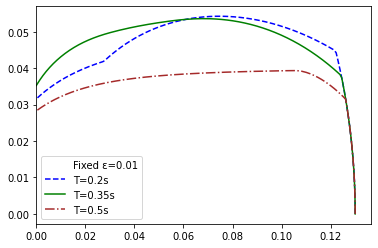

In [18]:
plot_fig3_left(max_ang_vel, max_vel)

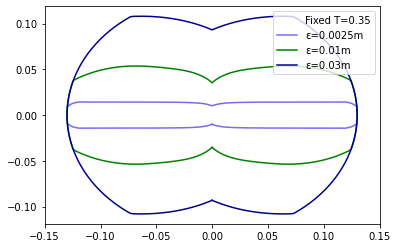

In [19]:
plot_fig3_right(max_ang_vel, max_vel)

Calculate PAHV, results can be configured by changing the tolerance

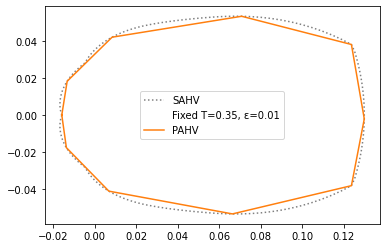

In [26]:
from shapely.geometry import Polygon
# Can be implemented in C++ orca library by using shapely's underlying GEOS library
# https://github.com/libgeos/geos, although it's recommended to tune the simplified
# contour manually here and load it to ensure a correct approximation
# https://github.com/libgeos/geos/blob/main/src/simplify/TopologyPreservingSimplifier.cpp

T = 0.35
error = 0.01
turn_values_360 = np.linspace(-np.pi, np.pi, 200)

def calculate_simplified_contour(max_ang_vel, max_vel, T, error, turn_values, tolerance):
    v_x, v_y = calculate_velocity_components(max_ang_vel, max_vel, T, error, turn_values)
    plt.plot(v_x, v_y, c="gray", marker='', ls=":", label="SAHV")

    closed_contour = np.stack((v_x, v_y), axis=1)
    closed_contour = Polygon(closed_contour)
    return closed_contour.simplify(tolerance=tolerance)

def plot_simplified_contour(simplified_contour: Polygon):
    if simplified_contour:
        plt.plot(*simplified_contour.boundary.xy, label="PAHV")

# simplified_contour = calculate_simplified_contour(max_ang_vel, max_vel, T, 0.0025, turn_values_360, 0.006)
simplified_contour = calculate_simplified_contour(max_ang_vel, max_vel, T, 0.01, turn_values_360, 0.006)
# simplified_contour = calculate_simplified_contour(max_ang_vel, max_vel, T, 0.03, turn_values_360, 0.01)
plot_experiment_values(T, error)
plot_simplified_contour(simplified_contour)
plt.legend()